<a href="https://colab.research.google.com/github/vishalgimhan/MachineLearning-Learn/blob/main/Data_Cleaning_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Handling Missing Values

In [2]:
#Connect Kaggle with Colab
#!pip install -q kaggle

In [3]:
# from google.colab import files

# files.upload()

In [4]:
#create folder named Kaggle
!mkdir -p ~/.kaggle

#copy kaggle.json into Kaggle Folder
!cp kaggle.json ~/.kaggle/

#Change permissions so that only you can read-write
!chmod 600 ~/.kaggle/kaggle.json

#Download dataset
#!kaggle datasets download -d <dataset-username>/<dataset-name>

#Unzip dataset
#!unzip -q dataset-name.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [5]:
#OR run this code to connect with Kaggle Data Sources

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'nflplaybyplay2009to2016:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1726%2F221448%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240502%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240502T051421Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5c1daf4709c9de57dfca1bf165dcd6870e8f881d3dd53576d559ea9603f394f955bf939a7a1a9de10ceaf374473e0dfd4fbebfddc94e876b68b7d860785a295671bd321c044a6c9b9e7a57de0e037fe552b5f0ce886337caae9819fd435043a4ed3439c9df4e3159c81726c7bdf288a7a98de5640fa2b4d03d2d3a20b6dcd3de59bcdd0b754e1d02684beed47a5892a56fd3451896d389f6baea508b1da1f700d84ea75a6faa70a5f3bf22f53fa21ecef9e727dcafa0a07f8c1e38e22fb6c91194596ed189bd2a20466baeede65d57c9cb947c7e6683fcee78da5fbbc5563ab2d22bcfdc5a01a18b3880ef334f94ee7c51aa002b200856132bcd3713b361b75d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 287411671 bytes downloaded
Downloaded and uncompressed: nflplaybyplay2009to2016
Data source import complete.


Take a first look at the data

In [6]:
# modules we'll use
import pandas as pd
import numpy as np

# read in all our data
nfl_data = pd.read_csv("../input/nflplaybyplay2009to2016/NFL Play by Play 2009-2017 (v4).csv")

# set seed for reproducibility
np.random.seed(0)

<ipython-input-6-792fdc80b577>:6: DtypeWarning: Columns (25,51) have mixed types. Specify dtype option on import or set low_memory=False.
  nfl_data = pd.read_csv("../input/nflplaybyplay2009to2016/NFL Play by Play 2009-2017 (v4).csv")


The first thing to do when you get a new dataset is take a look at some of it. Let's see if there are any missing values, which will be reprsented with NaN or None.

In [7]:
# look at the first five rows of the nfl_data file.
# I can see a handful of missing data already!
nfl_data.head()

,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,...,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
0,2009-09-10,2009091000,1,1,NaN,15:00,15,3600.0,0.0,TEN,...,NaN,0.485675,0.514325,0.546433,0.453567,0.485675,0.060758,NaN,NaN,2009
1,2009-09-10,2009091000,1,1,1.0,14:53,15,3593.0,7.0,PIT,...,1.146076,0.546433,0.453567,0.551088,0.448912,0.546433,0.004655,-0.032244,0.036899,2009
2,2009-09-10,2009091000,1,1,2.0,14:16,15,3556.0,37.0,PIT,...,NaN,0.551088,0.448912,0.510793,0.489207,0.551088,-0.040295,NaN,NaN,2009
3,2009-09-10,2009091000,1,1,3.0,13:35,14,3515.0,41.0,PIT,...,-5.031425,0.510793,0.489207,0.461217,0.538783,0.510793,-0.049576,0.106663,-0.156239,2009
4,2009-09-10,2009091000,1,1,4.0,13:27,14,3507.0,8.0,PIT,...,NaN,0.461217,0.538783,0.558929,0.441071,0.461217,0.097712,NaN,NaN,2009


How many missing data points do we have?

In [8]:
# get the number of missing data points per column
missing_values_count = nfl_data.isnull().sum()

# look at the # of missing points in the first ten columns
missing_values_count[0:10]

Date                0
GameID              0
Drive               0
qtr                 0
down            61154
time              224
TimeUnder           0
TimeSecs          224
PlayTimeDiff      444
SideofField       528
dtype: int64

That seems like a lot! It might be helpful to see what percentage of the values in our dataset were missing to give us a better sense of the scale of this problem:

In [9]:
# how many total missing values do we have?
total_cells = np.product(nfl_data.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

27.66722370547874


almost a quarter of the cells in this dataset are empty!

**Figure out why the data is missing**

For dealing with missing values, you'll need to use your intution to figure out why the value is missing. One of the most important questions you can ask yourself to help figure this out is this:

Is this value missing because it wasn't recorded or because it doesn't exist?

These values you probably do want to keep as NaN. On the other hand, if a value is missing because it wasn't recorded, then you can try to guess what it might have been based on the other values in that column and row. This is called imputation.

In [10]:
# look at the # of missing points in the first ten columns
missing_values_count[0:10]

Date                0
GameID              0
Drive               0
qtr                 0
down            61154
time              224
TimeUnder           0
TimeSecs          224
PlayTimeDiff      444
SideofField       528
dtype: int64

column "TimesSec" has a lot of missing values in it!

this column has information on the number of seconds left in the game when the play was made. This means that these values are probably missing because they were not recorded, rather than because they don't exist.

other fields, like "PenalizedTeam" that also have lot of missing fields. In this case, though, the field is missing because if there was no penalty then it doesn't make sense to say which team was penalized. So, it would make more sense to either leave it empty or to add a third value like "neither"

**Drop missing values**

if you're in a hurry or don't have a reason to figure out why your values are missing, one option you have is to just remove any rows or columns that contain missing values.

In [11]:
# remove all the rows that contain a missing value
nfl_data.dropna()

,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,...,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season


that's removed all our data!

In [12]:
# remove all columns with at least one missing value
columns_with_na_dropped = nfl_data.dropna(axis=1)
columns_with_na_dropped.head()

,Date,GameID,Drive,qtr,TimeUnder,ydstogo,ydsnet,PlayAttempted,Yards.Gained,sp,...,AwayTeam,Timeout_Indicator,posteam_timeouts_pre,HomeTimeouts_Remaining_Pre,AwayTimeouts_Remaining_Pre,HomeTimeouts_Remaining_Post,AwayTimeouts_Remaining_Post,ExPoint_Prob,TwoPoint_Prob,Season
0,2009-09-10,2009091000,1,1,15,0,0,1,39,0,...,TEN,0,3,3,3,3,3,0.0,0.0,2009
1,2009-09-10,2009091000,1,1,15,10,5,1,5,0,...,TEN,0,3,3,3,3,3,0.0,0.0,2009
2,2009-09-10,2009091000,1,1,15,5,2,1,-3,0,...,TEN,0,3,3,3,3,3,0.0,0.0,2009
3,2009-09-10,2009091000,1,1,14,8,2,1,0,0,...,TEN,0,3,3,3,3,3,0.0,0.0,2009
4,2009-09-10,2009091000,1,1,14,8,2,1,0,0,...,TEN,0,3,3,3,3,3,0.0,0.0,2009


In [13]:
# just how much data did we lose?
print("Columns in original dataset: %d \n" % nfl_data.shape[1])
print("Columns with na's dropped: %d" % columns_with_na_dropped.shape[1])

Columns in original dataset: 102 

Columns with na's dropped: 37


We've lost quite a bit of data, but at this point we have successfully removed all the NaN's from our data.

**Filling in missing values automatically**

In [14]:
# get a small subset of the NFL dataset
subset_nfl_data = nfl_data.loc[:, 'EPA':'Season'].head()
subset_nfl_data

,EPA,airEPA,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
0,2.014474,NaN,NaN,0.485675,0.514325,0.546433,0.453567,0.485675,0.060758,NaN,NaN,2009
1,0.077907,-1.068169,1.146076,0.546433,0.453567,0.551088,0.448912,0.546433,0.004655,-0.032244,0.036899,2009
2,-1.402760,NaN,NaN,0.551088,0.448912,0.510793,0.489207,0.551088,-0.040295,NaN,NaN,2009
3,-1.712583,3.318841,-5.031425,0.510793,0.489207,0.461217,0.538783,0.510793,-0.049576,0.106663,-0.156239,2009
4,2.097796,NaN,NaN,0.461217,0.538783,0.558929,0.441071,0.461217,0.097712,NaN,NaN,2009


Panda's fillna() function to fill in missing values in a dataframe

In [15]:
# replace all NA's with 0
subset_nfl_data.fillna(0)

,EPA,airEPA,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
0,2.014474,0.000000,0.000000,0.485675,0.514325,0.546433,0.453567,0.485675,0.060758,0.000000,0.000000,2009
1,0.077907,-1.068169,1.146076,0.546433,0.453567,0.551088,0.448912,0.546433,0.004655,-0.032244,0.036899,2009
2,-1.402760,0.000000,0.000000,0.551088,0.448912,0.510793,0.489207,0.551088,-0.040295,0.000000,0.000000,2009
3,-1.712583,3.318841,-5.031425,0.510793,0.489207,0.461217,0.538783,0.510793,-0.049576,0.106663,-0.156239,2009
4,2.097796,0.000000,0.000000,0.461217,0.538783,0.558929,0.441071,0.461217,0.097712,0.000000,0.000000,2009


replace missing values with whatever value comes directly after it in the same column

In [16]:
# replace all NA's the value that comes directly after it in the same column,
# then replace all the remaining na's with 0
subset_nfl_data.fillna(method='bfill', axis=0).fillna(0)

,EPA,airEPA,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
0,2.014474,-1.068169,1.146076,0.485675,0.514325,0.546433,0.453567,0.485675,0.060758,-0.032244,0.036899,2009
1,0.077907,-1.068169,1.146076,0.546433,0.453567,0.551088,0.448912,0.546433,0.004655,-0.032244,0.036899,2009
2,-1.402760,3.318841,-5.031425,0.551088,0.448912,0.510793,0.489207,0.551088,-0.040295,0.106663,-0.156239,2009
3,-1.712583,3.318841,-5.031425,0.510793,0.489207,0.461217,0.538783,0.510793,-0.049576,0.106663,-0.156239,2009
4,2.097796,0.000000,0.000000,0.461217,0.538783,0.558929,0.441071,0.461217,0.097712,0.000000,0.000000,2009


#Exercise

1) Take a first look at the data

In [18]:
# modules we'll use
import pandas as pd
import numpy as np

# read in all our data
sf_permits = pd.read_csv("/content/drive/MyDrive/Datasets/Building_Permits.csv")

# set seed for reproducibility
np.random.seed(0)

<ipython-input-18-3ad0f41dc595>:6: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  sf_permits = pd.read_csv("/content/drive/MyDrive/Datasets/Building_Permits.csv")


In [19]:
sf_permits.head(5)

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,...,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
0,201505065519,4,sign - erect,05/06/2015,0326,023,140,NaN,Ellis,St,...,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.785719256680785, -122.40852313194863)",1380611233945
1,201604195146,4,sign - erect,04/19/2016,0306,007,440,NaN,Geary,St,...,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.78733980600732, -122.41063199757738)",1420164406718
2,201605278609,3,additions alterations or repairs,05/27/2016,0595,203,1647,NaN,Pacific,Av,...,1.0,constr type 1,1.0,constr type 1,NaN,3.0,Russian Hill,94109.0,"(37.7946573324287, -122.42232562979227)",1424856504716
3,201611072166,8,otc alterations permit,11/07/2016,0156,011,1230,NaN,Pacific,Av,...,5.0,wood frame (5),5.0,wood frame (5),NaN,3.0,Nob Hill,94109.0,"(37.79595867909168, -122.41557405519474)",1443574295566
4,201611283529,6,demolitions,11/28/2016,0342,001,950,NaN,Market,St,...,3.0,constr type 3,NaN,NaN,NaN,6.0,Tenderloin,94102.0,"(37.78315261897309, -122.40950883997789)",144548169992


2) How many missing data points do we have?

In [20]:
# get the number of missing data points per column
missing_values_count = sf_permits.isnull().sum()

# how many total missing values do we have?
total_cells = np.product(sf_permits.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100

3) Figure out why the data is missing

In [21]:
print(missing_values_count)

Permit Number                                  0
Permit Type                                    0
Permit Type Definition                         0
Permit Creation Date                           0
Block                                          0
Lot                                            0
Street Number                                  0
Street Number Suffix                      196684
Street Name                                    0
Street Suffix                               2768
Unit                                      169421
Unit Suffix                               196939
Description                                  290
Current Status                                 0
Current Status Date                            0
Filed Date                                     0
Issued Date                                14940
Completed Date                            101709
First Construction Document Date           14946
Structural Notification                   191978
Number of Existing S

If a value in the "Street Number Suffix" column is missing, it is likely because it does not exist. If a value in the "Zipcode" column is missing, it was not recorded

4) Drop missing values: rows

In [22]:
columnsWithNa = sf_permits.dropna(axis=0)

In [23]:
columnsWithNa

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,...,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID


If you removed all of the rows of sf_permits with missing values, There are no rows remaining in the dataset!

5) Drop missing values: columns

In [24]:
# remove all columns with at least one missing value
sf_permits_with_na_dropped = sf_permits.dropna(axis=1)

# calculate number of dropped columns
cols_in_original_dataset = sf_permits.shape[1]
cols_in_na_dropped = sf_permits_with_na_dropped.shape[1]
dropped_columns = cols_in_original_dataset - cols_in_na_dropped

In [25]:
print(dropped_columns)

31


6) Fill in missing values automatically

replacing all the NaN's in the sf_permits data with the one that comes directly after it and then replacing any remaining NaN's with 0

In [26]:
sf_permits_with_na_imputed = sf_permits.fillna(method='bfill', axis=0).fillna(0)

In [27]:
sf_permits_with_na_imputed

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,...,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
0,201505065519,4,sign - erect,05/06/2015,0326,023,140,A,Ellis,St,...,3.0,constr type 3,1.0,constr type 1,Y,3.0,Tenderloin,94102.0,"(37.785719256680785, -122.40852313194863)",1380611233945
1,201604195146,4,sign - erect,04/19/2016,0306,007,440,A,Geary,St,...,3.0,constr type 3,1.0,constr type 1,Y,3.0,Tenderloin,94102.0,"(37.78733980600732, -122.41063199757738)",1420164406718
2,201605278609,3,additions alterations or repairs,05/27/2016,0595,203,1647,A,Pacific,Av,...,1.0,constr type 1,1.0,constr type 1,Y,3.0,Russian Hill,94109.0,"(37.7946573324287, -122.42232562979227)",1424856504716
3,201611072166,8,otc alterations permit,11/07/2016,0156,011,1230,A,Pacific,Av,...,5.0,wood frame (5),5.0,wood frame (5),Y,3.0,Nob Hill,94109.0,"(37.79595867909168, -122.41557405519474)",1443574295566
4,201611283529,6,demolitions,11/28/2016,0342,001,950,A,Market,St,...,3.0,constr type 3,1.0,constr type 1,Y,6.0,Tenderloin,94102.0,"(37.78315261897309, -122.40950883997789)",144548169992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198895,M862628,8,otc alterations permit,12/05/2017,0113,017A,1228,0,Montgomery,St,...,5.0,wood frame (5),5.0,wood frame (5),0,0.0,0,0.0,0,1489337276729
198896,201712055595,8,otc alterations permit,12/05/2017,0271,014,580,0,Bush,St,...,5.0,wood frame (5),5.0,wood frame (5),0,0.0,0,0.0,0,1489462354993
198897,M863507,8,otc alterations permit,12/06/2017,4318,019,1568,0,Indiana,St,...,0.0,0,0.0,0,0,0.0,0,0.0,0,1489539379952
198898,M863747,8,otc alterations permit,12/06/2017,0298,029,795,0,Sutter,St,...,0.0,0,0.0,0,0,0.0,0,0.0,0,1489608233656


#2. Scaling and Normalization

In [2]:
# modules we'll use
import pandas as pd
import numpy as np

# for Box-Cox Transformation
from scipy import stats

# for min_max scaling
from mlxtend.preprocessing import minmax_scaling

# plotting modules
import seaborn as sns
import matplotlib.pyplot as plt

# set seed for reproducibility
np.random.seed(0)

* in scaling, you're changing the range of your data, while
* in normalization, you're changing the shape of the distribution of your data.

You want to scale data when you're using methods based on measures of how far apart data points are, like support vector machines (SVM) or k-nearest neighbors (KNN). With these algorithms, a change of "1" in any numeric feature is given the same importance.

By scaling your variables, you can help compare different variables on equal footing.

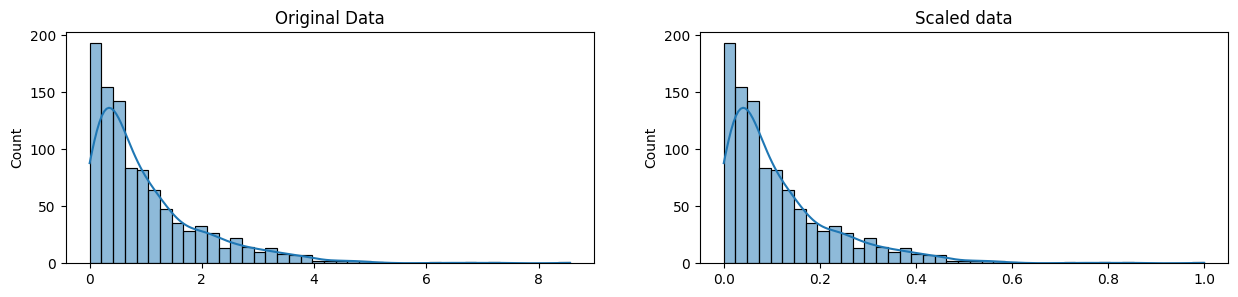

In [3]:
# generate 1000 data points randomly drawn from an exponential distribution
original_data = np.random.exponential(size=1000)

# mix-max scale the data between 0 and 1
scaled_data = minmax_scaling(original_data, columns=[0])

# plot both together to compare
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
sns.histplot(original_data, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(scaled_data, ax=ax[1], kde=True, legend=False)
ax[1].set_title("Scaled data")
plt.show()

Notice that the shape of the data doesn't change, but that instead of ranging from 0 to 8ish, it now ranges from 0 to 1.

#Normalization

Normalization is a more radical transformation. The point of normalization is to change your observations so that they can be described as a normal distribution.

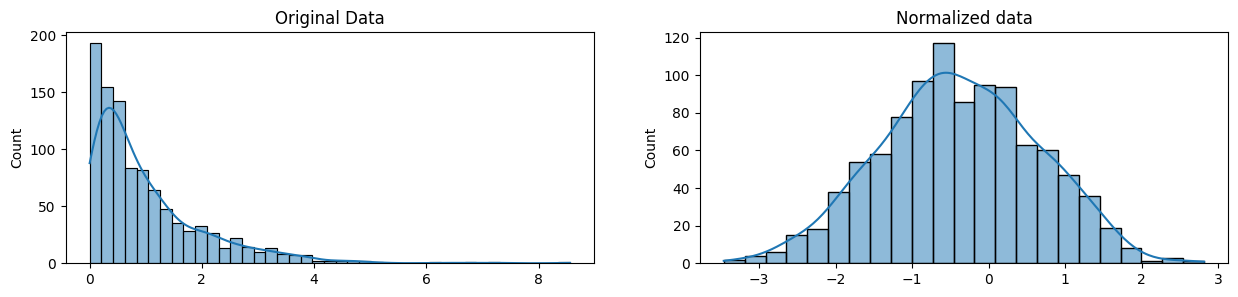

In [4]:
# normalize the exponential data with boxcox
normalized_data = stats.boxcox(original_data)

# plot both together to compare
fig, ax=plt.subplots(1, 2, figsize=(15, 3))
sns.histplot(original_data, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(normalized_data[0], ax=ax[1], kde=True, legend=False)
ax[1].set_title("Normalized data")
plt.show()

Notice that the shape of our data has changed. Before normalizing it was almost L-shaped. But after normalizing it looks more like the outline of a bell (hence "bell curve").

#Exercise

Get our environment set up

In [5]:
# modules we'll use
import pandas as pd
import numpy as np

# for Box-Cox Transformation
from scipy import stats

# for min_max scaling
from mlxtend.preprocessing import minmax_scaling

# plotting modules
import seaborn as sns
import matplotlib.pyplot as plt

# read in all our data
kickstarters_2017 = pd.read_csv("/content/drive/MyDrive/Datasets/kickstarter-projects-201801.csv")

# set seed for reproducibility
np.random.seed(0)

In [7]:
kickstarters_2017.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


scaling the goals of each campaign, which is how much money they were asking for.

In [8]:
# select the usd_goal_real column
original_data = pd.DataFrame(kickstarters_2017.usd_goal_real)

# scale the goals from 0 to 1
scaled_data = minmax_scaling(original_data, columns=['usd_goal_real'])

print('Original data\nPreview:\n', original_data.head())
print('Minimum value:', float(original_data.min()),
      '\nMaximum value:', float(original_data.max()))
print('_'*30)

print('\nScaled data\nPreview:\n', scaled_data.head())
print('Minimum value:', float(scaled_data.min()),
      '\nMaximum value:', float(scaled_data.max()))

Original data
Preview:
    usd_goal_real
0        1533.95
1       30000.00
2       45000.00
3        5000.00
4       19500.00
Minimum value: 0.01 
Maximum value: 166361390.71
______________________________

Scaled data
Preview:
    usd_goal_real
0       0.000009
1       0.000180
2       0.000270
3       0.000030
4       0.000117
Minimum value: 0.0 
Maximum value: 1.0


<ipython-input-8-b05f42876f40>:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('Minimum value:', float(original_data.min()),
<ipython-input-8-b05f42876f40>:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  '\nMaximum value:', float(original_data.max()))
<ipython-input-8-b05f42876f40>:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('Minimum value:', float(scaled_data.min()),
<ipython-input-8-b05f42876f40>:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  '\nMaximum value:', float(scaled_data.max()))


1) Practice scaling

We just scaled the "usd_goal_real" column. What about the "goal" column?

In [9]:
# select the usd_goal_real column
original_goal_data = pd.DataFrame(kickstarters_2017.goal)

In [10]:
scaled_goal_data = minmax_scaling(original_goal_data, columns=['goal'])

2) Practice normalization

In [11]:
# get the index of all positive pledges (Box-Cox only takes positive values)
index_of_positive_pledges = kickstarters_2017.usd_pledged_real > 0

# get only positive pledges (using their indexes)
positive_pledges = kickstarters_2017.usd_pledged_real.loc[index_of_positive_pledges]

# normalize the pledges (w/ Box-Cox)
normalized_pledges = pd.Series(stats.boxcox(positive_pledges)[0],
                               name='usd_pledged_real', index=positive_pledges.index)

print('Original data\nPreview:\n', positive_pledges.head())
print('Minimum value:', float(positive_pledges.min()),
      '\nMaximum value:', float(positive_pledges.max()))
print('_'*30)

print('\nNormalized data\nPreview:\n', normalized_pledges.head())
print('Minimum value:', float(normalized_pledges.min()),
      '\nMaximum value:', float(normalized_pledges.max()))

Original data
Preview:
 1     2421.0
2      220.0
3        1.0
4     1283.0
5    52375.0
Name: usd_pledged_real, dtype: float64
Minimum value: 0.45 
Maximum value: 20338986.27
______________________________

Normalized data
Preview:
 1    10.165142
2     6.468598
3     0.000000
4     9.129277
5    15.836853
Name: usd_pledged_real, dtype: float64
Minimum value: -0.7779954122762203 
Maximum value: 30.69054020451361


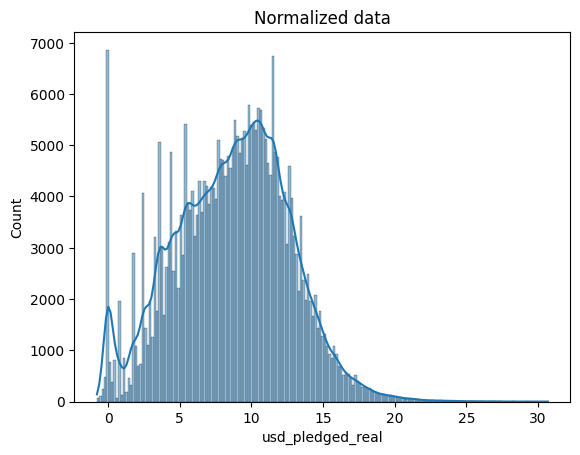

In [12]:
# plot normalized data
ax = sns.histplot(normalized_pledges, kde=True)
ax.set_title("Normalized data")
plt.show()

Text(0.5, 1.0, 'Normalized data')

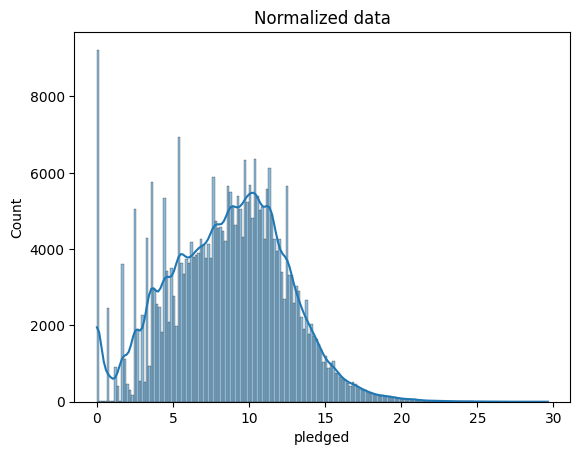

In [13]:
#Normalize "Pledged" Column

# get the index of all positive pledges (Box-Cox only takes positive values)
index_positive_pledges = kickstarters_2017.pledged > 0

# get only positive pledges (using their indexes)
positive_pledges_only = kickstarters_2017.pledged.loc[index_positive_pledges]

# normalize the pledges (w/ Box-Cox)
normalized_values = pd.Series(stats.boxcox(positive_pledges_only)[0],
                              name='pledged', index=positive_pledges_only.index)

# plot normalized data
ax = sns.histplot(normalized_values, kde=True)
ax.set_title("Normalized data")

#3. Parsing Dates

In [1]:
# modules we'll use
import pandas as pd
import numpy as np
import seaborn as sns
import datetime

# read in our data
landslides = pd.read_csv("/content/drive/MyDrive/Datasets/landslides_catalog.csv")

# set seed for reproducibility
np.random.seed(0)

Check the data type of our date column

In [2]:
landslides.head()

,id,date,time,continent_code,country_name,country_code,state/province,population,city/town,distance,...,geolocation,hazard_type,landslide_type,landslide_size,trigger,storm_name,injuries,fatalities,source_name,source_link
0,34,3/2/07,Night,NaN,United States,US,Virginia,16000,Cherry Hill,3.40765,...,"(38.600900000000003, -77.268199999999993)",Landslide,Landslide,Small,Rain,NaN,NaN,NaN,NBC 4 news,http://www.nbc4.com/news/11186871/detail.html
1,42,3/22/07,NaN,NaN,United States,US,Ohio,17288,New Philadelphia,3.33522,...,"(40.517499999999998, -81.430499999999995)",Landslide,Landslide,Small,Rain,NaN,NaN,NaN,Canton Rep.com,http://www.cantonrep.com/index.php?ID=345054&C...
2,56,4/6/07,NaN,NaN,United States,US,Pennsylvania,15930,Wilkinsburg,2.91977,...,"(40.4377, -79.915999999999997)",Landslide,Landslide,Small,Rain,NaN,NaN,NaN,The Pittsburgh Channel.com,https://web.archive.org/web/20080423132842/htt...
3,59,4/14/07,NaN,NaN,Canada,CA,Quebec,42786,Châteauguay,2.98682,...,"(45.322600000000001, -73.777100000000004)",Landslide,Riverbank collapse,Small,Rain,NaN,NaN,NaN,Le Soleil,http://www.hebdos.net/lsc/edition162007/articl...
4,61,4/15/07,NaN,NaN,United States,US,Kentucky,6903,Pikeville,5.66542,...,"(37.432499999999997, -82.493099999999998)",Landslide,Landslide,Small,Downpour,NaN,NaN,0.0,Matthew Crawford (KGS),NaN


In [3]:
# print the first few rows of the date column
print(landslides['date'].head())

0     3/2/07
1    3/22/07
2     4/6/07
3    4/14/07
4    4/15/07
Name: date, dtype: object


just because I, a human, can tell that these are dates doesn't mean that Python knows that they're dates.

Pandas uses the "object" dtype for storing various types of data types, but most often when you see a column with the dtype "object" it will have strings in it.

In [4]:
# check the data type of our date column
landslides['date'].dtype

dtype('O')

* b	boolean
* i	signed integer
* u	unsigned integer
* f	floating-point
* c	complex floating-point
* m	timedelta
* M	datetime
* O	object
* S	(byte-)string
* U	Unicode
* V	void



Convert our date columns to datetime

it's time to convert it so that it is recognized as a date. This is called "parsing dates"

We can determine what the format of our dates are with a guide called "strftime directive"

In [5]:
# create a new column, date_parsed, with the parsed dates
landslides['date_parsed'] = pd.to_datetime(landslides['date'], format="%m/%d/%y")

In [6]:
# print the first few rows
landslides['date_parsed'].head()

0   2007-03-02
1   2007-03-22
2   2007-04-06
3   2007-04-14
4   2007-04-15
Name: date_parsed, dtype: datetime64[ns]

ates have been slightly rearranged so that they fit the default order datetime objects (year-month-day)

What if I run into an error with multiple date formats?

If that happens, you can have pandas try to infer what the right date format should be. You can do that like so:

landslides['date_parsed'] = pd.to_datetime(landslides['Date'], infer_datetime_format=True)

Why don't you always use infer_datetime_format = True?
* pandas won't always been able to figure out the correct date format
* much slower than specifying the exact format of the dates.

Select the day of the month

In [7]:
# get the day of the month from the date_parsed column
day_of_month_landslides = landslides['date_parsed'].dt.day
day_of_month_landslides.head()

0     2.0
1    22.0
2     6.0
3    14.0
4    15.0
Name: date_parsed, dtype: float64

Plot the day of the month to check the date parsing

<ipython-input-8-cd6f9699bede>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(day_of_month_landslides, kde=False, bins=31)


<Axes: xlabel='date_parsed'>

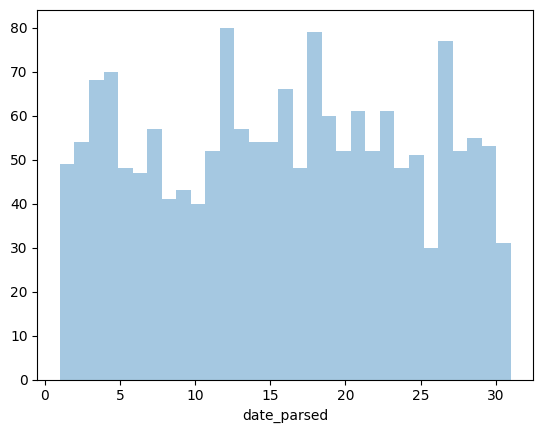

In [8]:
# remove na's
day_of_month_landslides = day_of_month_landslides.dropna()

# plot the day of the month
sns.distplot(day_of_month_landslides, kde=False, bins=31)

#Exercise

Get our environment set up

In [9]:
# modules we'll use
import pandas as pd
import numpy as np
import seaborn as sns
import datetime

# read in our data
earthquakes = pd.read_csv("/content/drive/MyDrive/Datasets/earthquake_database.csv")

# set seed for reproducibility
np.random.seed(0)

1) Check the data type of our date column

In [10]:
earthquakes['Date'].dtype

dtype('O')

In [11]:
earthquakes['Date'].head()

0    01/02/1965
1    01/04/1965
2    01/05/1965
3    01/08/1965
4    01/09/1965
Name: Date, dtype: object

2) Convert our date columns to datetime

Most of the entries in the "Date" column follow the same format: "month/day/four-digit year". However, the entry at index 3378 follows a completely different pattern.

In [12]:
earthquakes[3378:3383]

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
3378,1975-02-23T02:58:41.000Z,1975-02-23T02:58:41.000Z,8.017,124.075,Earthquake,623.0,NaN,NaN,5.6,MB,...,NaN,NaN,NaN,NaN,NaN,USP0000A09,US,US,US,Reviewed
3379,02/23/1975,03:53:36,-21.727,-71.356,Earthquake,33.0,NaN,NaN,5.6,MB,...,NaN,NaN,NaN,NaN,NaN,USP0000A0A,US,US,US,Reviewed
3380,02/23/1975,07:34:11,-10.879,166.667,Earthquake,33.0,NaN,NaN,5.5,MS,...,NaN,NaN,NaN,NaN,NaN,USP0000A0C,US,US,US,Reviewed
3381,02/25/1975,05:20:05,-7.388,149.798,Earthquake,33.0,NaN,NaN,5.5,MB,...,NaN,NaN,NaN,NaN,NaN,USP0000A12,US,US,US,Reviewed
3382,02/26/1975,04:48:55,85.047,97.969,Earthquake,33.0,NaN,NaN,5.6,MS,...,NaN,NaN,NaN,NaN,NaN,USP0000A1H,US,US,US,Reviewed


We can get an idea of how widespread this issue is by checking the length of each entry in the "Date" column.

In [13]:
date_lengths = earthquakes.Date.str.len()
date_lengths.value_counts()

Date
10    23409
24        3
Name: count, dtype: int64

Looks like there are two more rows that has a date in a different format.
Let's obtain their indices

In [14]:
indices = np.where([date_lengths == 24])[1]
print('Indices with corrupted data:', indices)
earthquakes.loc[indices]

Indices with corrupted data: [ 3378  7512 20650]


,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
3378,1975-02-23T02:58:41.000Z,1975-02-23T02:58:41.000Z,8.017,124.075,Earthquake,623.0,NaN,NaN,5.6,MB,...,NaN,NaN,NaN,NaN,NaN,USP0000A09,US,US,US,Reviewed
7512,1985-04-28T02:53:41.530Z,1985-04-28T02:53:41.530Z,-32.998,-71.766,Earthquake,33.0,NaN,NaN,5.6,MW,...,NaN,NaN,NaN,NaN,1.30,USP0002E81,US,US,HRV,Reviewed
20650,2011-03-13T02:23:34.520Z,2011-03-13T02:23:34.520Z,36.344,142.344,Earthquake,10.1,13.9,289.0,5.8,MWC,...,NaN,32.3,NaN,NaN,1.06,USP000HWQP,US,US,GCMT,Reviewed


In [15]:
earthquakes.loc[3378, 'Date'] = "02/23/1975"
earthquakes.loc[7512, 'Date'] = "04/28/1985"
earthquakes.loc[20650, 'Date'] = "03/13/2011"
earthquakes['date_parsed'] = pd.to_datetime(earthquakes['Date'], format="%m/%d/%Y")

3) Select the day of the month

In [16]:
day_of_month_earthquakes = earthquakes['date_parsed'].dt.day

4) Plot the day of the month to check the date parsing

<ipython-input-17-bafecaeaf74f>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(day_of_month_earthquakes, kde=False, bins=31)


<Axes: xlabel='date_parsed'>

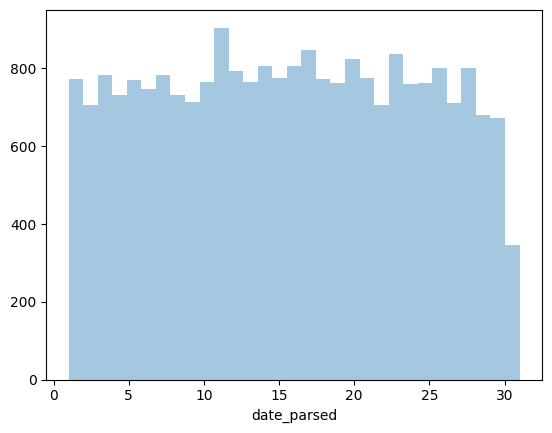

In [17]:
sns.distplot(day_of_month_earthquakes, kde=False, bins=31)

#4. Character Encodings

Get our environment set up

In [ ]:
# modules we'll use
import pandas as pd
import numpy as np

# helpful character encoding module
import charset_normalizer

# set seed for reproducibility
np.random.seed(0)

Character encodings are specific sets of rules for mapping from raw binary byte strings (that look like this: 0110100001101001) to characters that make up human-readable text (like "hi").

There are lots of different character encodings, but the main one you need to know is UTF-8.

In [18]:
# start with a string
before = "This is the euro symbol: €"

# check to see what datatype it is
type(before)

str

The other data is the bytes data type, which is a sequence of integers. You can convert a string into bytes by specifying which encoding it's in:

In [19]:
# encode it to a different encoding, replacing characters that raise errors
after = before.encode("utf-8", errors="replace")

# check the type
type(after)

bytes

If you look at a bytes object, you'll see that it has a b in front of it. Here you can see that our euro symbol has been replaced with some mojibake that looks like "\xe2\x82\xac" when it's printed as if it were an ASCII string.

In [20]:
# take a look at what the bytes look like
after

b'This is the euro symbol: \xe2\x82\xac'

When we convert our bytes back to a string with the correct encoding, we can see that our text is all there correctly, which is great! :)

In [21]:
# convert it back to utf-8
print(after.decode("utf-8"))

This is the euro symbol: €


However, when we try to use a different encoding to map our bytes into a string, we get an error.

In [22]:
# try to decode our bytes with the ascii encoding
print(after.decode("ascii"))

UnicodeDecodeError: 'ascii' codec can't decode byte 0xe2 in position 25: ordinal not in range(128)

We can also run into trouble if we try to use the wrong encoding to map from a string to bytes. Like I said earlier, strings are UTF-8 by default in Python 3, so if we try to treat them like they were in another encoding we'll create problems.

In [23]:
# start with a string
before = "This is the euro symbol: €"

# encode it to a different encoding, replacing characters that raise errors
after = before.encode("ascii", errors = "replace")

# convert it back to utf-8
print(after.decode("ascii"))

# We've lost the original underlying byte string! It's been
# replaced with the underlying byte string for the unknown character :(

This is the euro symbol: ?


Reading in files with encoding problems

In [26]:
# try to read in a file not in UTF-8
kickstarter_2016 = pd.read_csv("/content/drive/MyDrive/Datasets/kickstarter-projects-201612.csv")

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x99 in position 7955: invalid start byte

Notice that we get the same UnicodeDecodeError we got when we tried to decode UTF-8 bytes as if they were ASCII! This tells us that this file isn't actually UTF-8. We don't know what encoding it actually is though

In [29]:
import charset_normalizer

# look at the first ten thousand bytes to guess the character encoding
with open("/content/drive/MyDrive/Datasets/kickstarter-projects-201612.csv", 'rb') as rawdata:
    result = charset_normalizer.detect(rawdata.read(10000))

# check what the character encoding might be
print(result)

{'encoding': 'windows-1250', 'language': 'English', 'confidence': 1.0}


So charset_normalizer is 100% confidence that the right encoding is "Windows-1252".

In [30]:
# read in the file with the encoding detected by charset_normalizer
kickstarter_2016 = pd.read_csv("/content/drive/MyDrive/Datasets/kickstarter-projects-201612.csv", encoding='Windows-1252')

# look at the first few lines
kickstarter_2016.head()

<ipython-input-30-d4a1e290844b>:2: DtypeWarning: Columns (13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  kickstarter_2016 = pd.read_csv("/content/drive/MyDrive/Datasets/kickstarter-projects-201612.csv", encoding='Windows-1252')


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,NaN,NaN,NaN,NaN
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,NaN,NaN,NaN,NaN
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1,NaN,NaN,NaN,NaN
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,NaN
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375,NaN,NaN,NaN,NaN


Saving your files with UTF-8 encoding

In [ ]:
# save our file (will be saved as UTF-8 by default!)
#kickstarter_2016.to_csv("ks-projects-201801-utf8.csv")

#Exercise

# save our file (will be saved as UTF-8 by default!)
kickstarter_2016.to_csv("ks-projects-201801-utf8.csv")

In [ ]:
# modules we'll use
import pandas as pd
import numpy as np

# helpful character encoding module
import charset_normalizer

# set seed for reproducibility
np.random.seed(0)

1) What are encodings?

In [ ]:
sample_entry = b'\xa7A\xa6n'
print(sample_entry)
print('data type:', type(sample_entry))

create a variable new_entry that changes the encoding from "big5-tw" to "utf-8". new_entry should have the bytes datatype.

In [ ]:
new_entry = sample_entry.decode("big5-tw").encode("utf-8")

2) Reading in files with encoding problems

In [31]:
# TODO: Load in the DataFrame correctly.
with open("/content/drive/MyDrive/Datasets/PoliceKillingsUS.csv", 'rb') as rawdata:
    result = charset_normalizer.detect(rawdata.read(100000))

print(result)

{'encoding': 'windows-1250', 'language': 'English', 'confidence': 1.0}


In [32]:
police_killings = pd.read_csv("/content/drive/MyDrive/Datasets/PoliceKillingsUS.csv", encoding="windows-1250")

3) Saving your files with UTF-8 encoding

In [ ]:
# TODO: Save the police killings dataset to CSV
#police_killings.to_csv("police_killings.csv")

#Inconsistent Data Entry


Get our environment set up

In [34]:
#!pip install fuzzywuzzy

In [35]:
# modules we'll use
import pandas as pd
import numpy as np

# helpful modules
import fuzzywuzzy
from fuzzywuzzy import process
import charset_normalizer

# read in all our data
professors = pd.read_csv("/content/drive/MyDrive/Datasets/pakistan_intellectual_capital.csv")

# set seed for reproducibility
np.random.seed(0)

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Do some preliminary text pre-processing

In [36]:
professors.head()

,Unnamed: 0,S#,Teacher Name,University Currently Teaching,Department,Province University Located,Designation,Terminal Degree,Graduated from,Country,Year,Area of Specialization/Research Interests,Other Information
0,2,3,Dr. Abdul Basit,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,Software Engineering & DBMS,NaN
1,4,5,Dr. Waheed Noor,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,DBMS,NaN
2,5,6,Dr. Junaid Baber,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,"Information processing, Multimedia mining",NaN
3,6,7,Dr. Maheen Bakhtyar,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,"NLP, Information Retrieval, Question Answering...",NaN
4,24,25,Samina Azim,Sardar Bahadur Khan Women's University,Computer Science,Balochistan,Lecturer,BS,Balochistan University of Information Technolo...,Pakistan,2005.0,VLSI Electronics DLD Database,NaN


ay we're interested in cleaning up the "Country" column to make sure there's no data entry inconsistencies in it. We could go through and check each row by hand, of course, and hand-correct inconsistencies when we find them. There's a more efficient way to do this, though!

In [37]:
# get all the unique values in the 'Country' column
countries = professors['Country'].unique()

# sort them alphabetically and then take a closer look
countries.sort()
countries

array([' Germany', ' New Zealand', ' Sweden', ' USA', 'Australia',
       'Austria', 'Canada', 'China', 'Finland', 'France', 'Greece',
       'HongKong', 'Ireland', 'Italy', 'Japan', 'Macau', 'Malaysia',
       'Mauritius', 'Netherland', 'New Zealand', 'Norway', 'Pakistan',
       'Portugal', 'Russian Federation', 'Saudi Arabia', 'Scotland',
       'Singapore', 'South Korea', 'SouthKorea', 'Spain', 'Sweden',
       'Thailand', 'Turkey', 'UK', 'USA', 'USofA', 'Urbana', 'germany'],
      dtype=object)

some problems due to inconsistent data entry: ' Germany', and 'germany', for example, or ' New Zealand' and 'New Zealand'.

The first thing is make everything lower case  and remove any white spaces at the beginning and end of cells.

Inconsistencies in capitalizations and trailing white spaces are very common in text data and you can fix a good 80% of your text data entry inconsistencies by doing this.

In [ ]:
# convert to lower case
professors['Country'] = professors['Country'].str.lower()
# remove trailing white spaces
professors['Country'] = professors['Country'].str.strip()

Use fuzzy matching to correct inconsistent data entry

In [ ]:
# get all the unique values in the 'Country' column
countries = professors['Country'].unique()

# sort them alphabetically and then take a closer look
countries.sort()
countries

It does look like there is another inconsistency: 'southkorea' and 'south korea' should be the same.

It does look like there is another inconsistency: 'southkorea' and 'south korea' should be the same.

Fuzzy matching: The process of automatically finding text strings that are very similar to the target string. In general, a string is considered "closer" to another one the fewer characters you'd need to change if you were transforming one string into another.

Fuzzywuzzy returns a ratio given two strings. The closer the ratio is to 100, the smaller the edit distance between the two strings. Here, we're going to get the ten strings from our list of cities that have the closest distance to "south korea".

In [38]:
# get the top 10 closest matches to "south korea"
matches = fuzzywuzzy.process.extract("south korea", countries, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

# take a look at them
matches

[('South Korea', 100),
 ('SouthKorea', 48),
 ('Saudi Arabia', 43),
 ('Norway', 35),
 ('Ireland', 33),
 ('Portugal', 32),
 ('Singapore', 30),
 ('Netherland', 29),
 ('Macau', 25),
 ('USofA', 25)]

Let's replace all rows in our "Country" column that have a ratio of > 47 with "south korea".

In [39]:
# function to replace rows in the provided column of the provided dataframe
# that match the provided string above the provided ratio with the provided string
def replace_matches_in_column(df, column, string_to_match, min_ratio = 47):
    # get a list of unique strings
    strings = df[column].unique()

    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings,
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches
    df.loc[rows_with_matches, column] = string_to_match

    # let us know the function's done
    print("All done!")

Now that we have a function, we can put it to the test!

In [40]:
# use the function we just wrote to replace close matches to "south korea" with "south korea"
replace_matches_in_column(df=professors, column='Country', string_to_match="south korea")

All done!


And now let's check the unique values in our "Country" column again and make sure we've tidied up "south korea" correctly.

In [ ]:
# get all the unique values in the 'Country' column
countries = professors['Country'].unique()

# sort them alphabetically and then take a closer look
countries.sort()
countries

#Exercise

Get our environment set up

In [41]:
# modules we'll use
import pandas as pd
import numpy as np

# helpful modules
import fuzzywuzzy
from fuzzywuzzy import process
import charset_normalizer

# read in all our data
professors = pd.read_csv("/content/drive/MyDrive/Datasets/pakistan_intellectual_capital.csv")

# set seed for reproducibility
np.random.seed(0)

In [43]:
# convert to lower case
professors['Country'] = professors['Country'].str.lower()
# remove trailing white spaces
professors['Country'] = professors['Country'].str.strip()

# get the top 10 closest matches to "south korea"
countries = professors['Country'].unique()
matches = fuzzywuzzy.process.extract("south korea", countries, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
matches

[('south korea', 100),
 ('southkorea', 48),
 ('saudi arabia', 43),
 ('norway', 35),
 ('ireland', 33),
 ('portugal', 32),
 ('singapore', 30),
 ('netherland', 29),
 ('usofa', 25),
 ('macau', 25)]

In [44]:
def replace_matches_in_column(df, column, string_to_match, min_ratio = 47):
    # get a list of unique strings
    strings = df[column].unique()

    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings,
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches
    df.loc[rows_with_matches, column] = string_to_match

    # let us know the function's done
    print("All done!")

replace_matches_in_column(df=professors, column='Country', string_to_match="south korea")
countries = professors['Country'].unique()

All done!


1) Examine another column

In [45]:
Graduated_from = professors['Graduated from'].unique()
Graduated_from

array(['Asian Institute of Technology',
       'Balochistan University of Information Technology, Engineering and Management Sciences',
       'University of Balochistan',
       "Sardar Bahadur Khan Women's University",
       'SRH Hochschule Heidelberg',
       'Institute of Business Administration,Karachi', 'DUET,Karachi',
       'University of Turbat', 'University of Vienna',
       'Monash University', 'University of Stirling',
       'Chinese Academy of Sciences', 'University of Innsbruck',
       'Vienna University of Technology', 'University of Paris-Est',
       'The University of Cambridge', 'Harbin Institute of Technology',
       'University of Nice, Sophia Antipolis', 'The University of York',
       'Galilée - Université Paris 13', 'University of Bedfordshire',
       'North Dakota State University', 'Kyungpook National University',
       'The University of Manchester',
       'National University of Sciences and Technology',
       'FAST– National University of Computer

2) Do some text pre-processing

In [47]:
professors['Graduated from'] = professors['Graduated from'].str.strip()

3) Continue working with countries

In [46]:
# get all the unique values in the 'City' column
countries = professors['Country'].unique()

# sort them alphabetically and then take a closer look
countries.sort()
countries

array(['australia', 'austria', 'canada', 'china', 'finland', 'france',
       'germany', 'greece', 'hongkong', 'ireland', 'italy', 'japan',
       'macau', 'malaysia', 'mauritius', 'netherland', 'new zealand',
       'norway', 'pakistan', 'portugal', 'russian federation',
       'saudi arabia', 'scotland', 'singapore', 'south korea', 'spain',
       'sweden', 'thailand', 'turkey', 'uk', 'urbana', 'usa', 'usofa'],
      dtype=object)

Take another look at the "Country" column and see if there's any more data cleaning we need to do.

It looks like 'usa' and 'usofa' should be the same country. Correct the "Country" column in the dataframe to replace 'usofa' with 'usa'.

In [48]:
matches = fuzzywuzzy.process.extract("usa", countries, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
matches


[('usa', 100),
 ('usofa', 75),
 ('austria', 60),
 ('australia', 50),
 ('spain', 50),
 ('urbana', 44),
 ('uk', 40),
 ('malaysia', 36),
 ('pakistan', 36),
 ('portugal', 36)]

In [49]:
replace_matches_in_column(professors, column='Country', string_to_match="usa", min_ratio=70)

All done!


In [51]:
countries = professors['Country'].unique()
countries.sort()
countries

array(['australia', 'austria', 'canada', 'china', 'finland', 'france',
       'germany', 'greece', 'hongkong', 'ireland', 'italy', 'japan',
       'macau', 'malaysia', 'mauritius', 'netherland', 'new zealand',
       'norway', 'pakistan', 'portugal', 'russian federation',
       'saudi arabia', 'scotland', 'singapore', 'south korea', 'spain',
       'sweden', 'thailand', 'turkey', 'uk', 'urbana', 'usa'],
      dtype=object)